## Water volume balance through the faces of the shelf box

Why do I get positive water transport in the no canyon case if it should be balanced? Where did I screw up?

**Answer**: I never multiplied the thickness $drf$ by the fraction of open cell at the south of the cell $hfacS$ so the area of the cells ($dxg\times drf$) where water upwelled onto the shelf (close to the shelf bottom) were overestimated!

DUMB

Now, the plot at the end of this notebook shows a nice balanced shelf. Although the transport is slightly offshore throughout the simulation it can be explained by the drop in sea surface height.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [133]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty


In [4]:
# No-canyon files
Grid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc' 
Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc' 
State = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/stateGlob.nc' 
Flux = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/FluxTR01Glob.nc'

In [102]:
# Define shelf box indices
# E = east boundary, 
# W = west boundary, 
# N = north boundary (open coast), 
# S = south boundary (virtual wall from surface to shelf break).

Zind = slice(0,31)

Nx = slice(0,360) # open
Ny = 358           

Sx = slice(0,360) # open
Sy = 227

Wx = 0
Wy = slice(227,359) # periodic

Ex = 359
Ey = slice(227,359) # periodic

Lidx = slice(0,360)
Lidy = slice(227,359)
Lidz = 30

In [129]:
# Grid variables - these are the same for N and S
with Dataset(Grid, 'r') as nbl:
    dxg = nbl.variables['dxG'][Sy,Sx]
    dyg = nbl.variables['dyG'][Ey,Ex]
    drf = nbl.variables['drF'][Zind]
    depth = nbl.variables['Z'][Zind]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    ra = nbl.variables['rA'][Lidy,Lidx]
    hfacsS = nbl.variables['HFacS'][:31,Sy,Sx]
    hfacsN = nbl.variables['HFacS'][:31,Ny,Nx]


dxg_exp = np.expand_dims(dxg,0)
dyg_exp = np.expand_dims(dyg,0)
drf_exp = np.expand_dims(drf,1)
dxg_exp = dxg_exp + np.zeros(np.shape(hfacs))
dyg_exp = dyg_exp + np.zeros((len(range(31)),len(range(359-227))))
drf_exp = drf_exp + np.zeros(np.shape(hfacs))

In [131]:
# Calculate transport as u_i*A_i where u_i is the perpendicular velocity to the area A_i for cell i.
# East and west balance each other becasue bcs are periodic so I won't add them.
#
# Do I need to unstagger u,v?
#

# Shelf break
with Dataset(State, 'r') as nbl:
    v_south = nbl.variables['V'][:,Zind,Sy,Sx]
    S_trans = v_south*dxg_exp*hfacsS*drf_exp    # I didn't multiply by hfacS in my previous calculations
    v_north = nbl.variables['V'][:,Zind,Ny,Nx]
    N_trans = v_north*dxg_exp*hfacsN*drf_exp 
    u_east = nbl.variables['U'][:,Zind,Ey,Ex]
    E_trans = u_east*dyg_exp*drf_exp[:,Ey]
    u_west = nbl.variables['U'][:,Zind,Wy,Wx]
    W_trans = u_west*dyg_exp*drf_exp[:,Ey] 
    
    eta = nbl.variables['Eta'][:,Lidy,Lidx]     # approximation of volume change due to ssh drop
    eta_trans = ((eta[1:]-eta[:-1])*ra)/(3600*12)
    
    w_lid = nbl.variables['W'][:,Lidz,Lidy,Lidx]
    Lid_trans = w_lid*ra


S_trans_ts = np.sum(np.sum(S_trans,axis=1),axis=1)
N_trans_ts = np.sum(np.sum(N_trans,axis=1),axis=1)
E_trans_ts = np.sum(np.sum(E_trans,axis=1),axis=1)
W_trans_ts = np.sum(np.sum(W_trans,axis=1),axis=1)

eta_trans_ts = np.sum(np.sum(eta_trans,axis=1),axis=1)
Lid_trans_ts = np.sum(np.sum(Lid_trans,axis=1),axis=1)


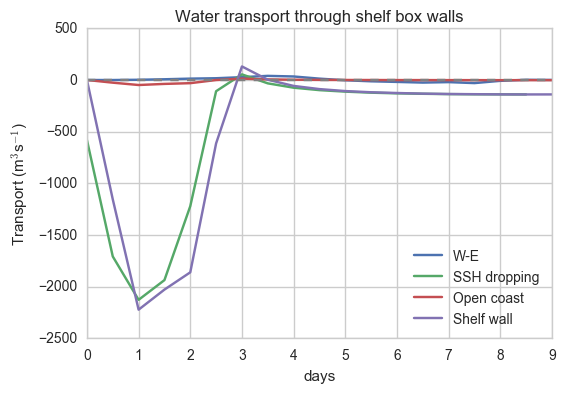

In [138]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(np.arange(19)/2,W_trans_ts-E_trans_ts, label='W-E')
ax.plot(np.arange(18)/2,eta_trans_ts, label='SSH dropping')
ax.plot(np.arange(19)/2,N_trans_ts,label='Open coast')
ax.plot(np.arange(19)/2,S_trans_ts,label='Shelf wall')
ax.set_title('Water transport through shelf box walls')
ax.set_xlabel('days')
ax.set_ylabel('Transport (m$^3$s$^{-1}$)')
ax.legend(loc=0)
ax.axhline(0,color='0.5',linestyle='--')

Note that all the water that leaves the shelf (Shelf wall) is the same as the water transport due to the sea surface height drop. 